# CS4220 Project 2 - Pathogen Detection

In this notebook, we give an example to show how to read and use the DNA read data. We will train one base line model, using `sklearn.LogisticRegression`, and use it to predict the pathogens in each patient's dataset.

## Related python packages

To get started (if you are using python), you may want to create a virtual python environment and install some packages. Here are some of the commands you might need:

```bash
conda create --name cs4220 python=3.8

# Install jupyter notebook if you are using it
conda install -c anaconda ipykernel
python -m ipykernel install --user --name=cs4220
conda install -c anaconda jupyter

# Some common packages
conda install pandas                      # for reading csv
conda install scikit-learn                # for the logistic regression model
pip install pytorch                       # if you are using neural networks
conda install -c conda-forge matplotlib   # for plotting
conda install seaborn                     # also for plotting
pip install umap-learn[plot]              # plotting UMAP plots
conda install numpy                       # for many math/vectorized operations
```

In [21]:
# import packages

import numpy as np
import pandas as pd
import timeit
import time
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
from umap.umap_ import UMAP


In [22]:
import datashader as ds
import datashader.transfer_functions as tf
import datashader.bundling as bd
import colorcet
import matplotlib.cm
import bokeh.plotting as bpl
import bokeh.transform as btr
import holoviews as hv
import holoviews.operation.datashader as hd

In [23]:
import umap.plot
import torch

In [24]:
# Check the current working directory

%pwd

'/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection'

## Parsing Input Data

First, some dataset statistics. We load our training labels (ground truth) and see how many reads a category (species) have.

In [25]:
label_df = pd.read_csv('./training_data/train_labels.csv')
print(sum(label_df['species_name'].value_counts()))
label_df['species_name'].value_counts()

461581


species_name
decoy                              413476
burkholderia_pseudomallei            3533
pseudomonas_aeruginosa               3126
klebsiella_michiganensis             2989
mycobacterium_ulcerans               2910
klebsiella_pneumoniae                2806
serratia_liquefaciens                2629
vibrio_parahaemolyticus              2579
salmonella_enterica_typhimurium      2507
yersinia_enterocolitica              2276
stenotrophomonas_maltophilia         2217
mycobacterium_tuberculosis           2175
clostridioides_difficile             2007
acinetobacter_baumannii              1964
legionella_pneumophila               1753
listeria_monocytogenes               1479
staphylococcus_aureus                1384
staphylococcus_pseudintermedius      1328
corynebacterium_ulcerans             1266
corynebacterium_diphtheriae          1194
streptococcus_suis                   1092
neisseria_gonorrhoeae                1087
streptococcus_agalactiae             1060
streptococcus_pneumon

It seems that we have a lot of decoy reads (decoy means sequencing reads from human or commensal species).

In [26]:
# snippet to load the grouth truth training labels and normalize the label predictions.
# your trained model will predict in this space (26 classes - pathogens and decoy)
le = preprocessing.LabelEncoder()
le.fit(label_df['species_name'].unique())
y_index = le.transform(label_df['species_name'].values)
label_df['labels'] = y_index
#this label_df will have label index instead of the actual class value

In [27]:
print(len(label_df['species_name'].unique()))
label_df

26


,species_name,labels
0,acinetobacter_baumannii,0
1,acinetobacter_baumannii,0
2,acinetobacter_baumannii,0
3,acinetobacter_baumannii,0
4,acinetobacter_baumannii,0
...,...,...
461576,decoy,6
461577,decoy,6
461578,decoy,6
461579,decoy,6


We are not training using the full dataset to provide a quick baseline here. Thus, we subsampled so that each category has 500 reads. Up to you to come up with interesting training strategies to use your full training dataset (or even your own datasets)!

In [28]:
samples_index = label_df.groupby('labels').sample(500).index
samples_index
#500 here means that there are at most 500 per label class
# find ways to reduce the sample size as there are >10000 samples

Index([ 1362,   937,  1622,  1196,  1309,  1070,  1084,   593,   547,   377,
       ...
       47238, 47869, 46331, 45895, 47716, 46128, 46859, 46559, 45832, 46754],
      dtype='int64', length=13000)

In this project, we try to use canonical $k$-mer profiles to represent each read in the input. Here, we are using $k=6$ and consequently 2081 features (including 1 feature `IGNORE` for ambiguous $k$-mer) for each read. Read [this reference](https://bioinfologics.github.io/post/2018/09/17/k-mer-counting-part-i-introduction/) for more information.

To help you save time, we implemented a utility class `CS4220Dataset` that can
- take in raw reads as input (`.fasta`, `.fa` files), and turn them into $k$-mer profiles, or
- take in $k$-mer profile as input (`.npy` files),
- allow you to sample data or create $k$-mer profile on the fly (during training) to save memory.

In [29]:
# Load dictionary that maps k-mer to their corresponding index.
# A k-mer and its reverse complement are mapped to the same index.

import json

with open("./training_data/6-mers.json", 'r') as dict_file:
    canonical_kmer_dict = json.load(dict_file)

    
# help to do label encoding on the reads values we used for ML training

In [30]:
# We define a utility function here that turns sequences to their 6-mer profiles.
# This is to allow the fasta file to be converted to data simialr npy file

def sequence_to_kmer_profile(sequence : str, k : int = 6):
    """
    Return the k-mer profile of the input sequence (string)
    """
    res = np.zeros(len(set(canonical_kmer_dict.values()))) # values for the dict is the labels encoded for the reads
    for i in range(len(sequence) - k + 1): #iterate through all the kmers within the seqeunce
        k_mer = sequence[i:i + k]
        if k_mer in canonical_kmer_dict: #if found in the available dict
            res[canonical_kmer_dict[k_mer]] += 1 #index of the res will be the label encoded for the reads while the actual value will be the counts
        else:
            res[-1] += 1 #count those invalid reads

    res /= np.sum(res)
    return res

In [31]:
import torch
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

class CS4220Dataset(Dataset):
    def __init__(self, data_file, label_df=None, k=6, samples_index=None, kmer_profile_on_the_fly=False, dtype=np.float32):
        """
        Dataset class to load large CS4220 sequence database.

        Args:
            - data_file (`str`): Can either be a *.fasta file if the input is raw reads, or *.npy file
                                 if the input is k-mer profile.
            - label_df (`pd.DataFrame` or `None`): A dataframe with "labels" column indicating the label
                                                   of the data (must match with data_file), or `None` if there is
                                                   no label (in the case of test sets).
            - k (`int`): The lengt of k-mer. We use 6 in this project.
            - samples_index (`List` or `None`): list of indices of data we sample from the data file. You
                                                can use this if the dataset is very large and can't fit in memory.
                                                set this to `None` if you want to use all the data.
            - kmer_profile_on_the_fly (`bool`): If input data_file is raw reads and this set to `True`,
                                                we will build k-mer profile on the fly. This is helpful if you want to
                                                alter the input sequences during training, or the k-mer profile can't fit in memory.
                                                Otherwise, we build k-mer profile in advance, which will speed up the
                                                training process.
            - dtype: type to store the k-mer profile. You may use, for example, `np.float32` for better precision,
                     or `np.float16` for smaller memory usage. If loaded from ".npy" file, it is always `np.float16`.
        """
        self.data_file = data_file

        if ".fasta" in data_file or ".fa" in data_file or ".fna" in data_file:
            self.is_raw_reads = True
        elif ".npy" in data_file:
            self.is_raw_reads = False
        else:
            raise TypeError(f"The input file must be either a fasta file containing raw reads (.fasta, .fa, .fna) or a numpy file containing k-mer profiles (.npy).")


        self.label_df = label_df
        self.kmer_profile_otf = kmer_profile_on_the_fly

        # k-mer length, set to be 6.
        self.k = k

        # the samples we take from the read dataset
        self.samples_index = samples_index

        self.dtype = dtype

        # Load the data and store in self.reads and self.labels
        self.X = []
        self.Y = []
        self._read_labels()
        self._read_data()
        


    def _read_labels(self):
        """
        Read the labels and record them in self.labels.
        """
        if self.label_df is None:
            self.Y = None
        elif self.samples_index is None:
            # Load the whole dataset
            self.Y = list(self.label_df["labels"])
        else:
            # Load only the data corresponding to the sampled index
            self.Y = list(self.label_df.iloc[self.samples_index]["labels"])


    def _read_data(self):
        if self.is_raw_reads:
            # Read the fasta file
            with open(self.data_file, 'r') as fasta_file:
                lines = fasta_file.readlines()

            read_range = self.samples_index if self.samples_index is not None else range(int(len(lines) / 2))
            if not self.kmer_profile_otf:
                self.X = np.zeros(
                    (len(read_range), len(set(canonical_kmer_dict.values()))),
                    dtype=self.dtype
                )

            for i, j in enumerate(tqdm(read_range, desc=f"Parsing fasta file {self.data_file}")):
                read = lines[j * 2 + 1].strip()
                if self.kmer_profile_otf:
                    # If chose to do k-mer profiling on the fly, simply store the reads
                    self.X.append(read)
                else:
                    # Otherwise, do k-mer profiling during training/testing, cost more time during training/testing
                    self.X[i, :] = sequence_to_kmer_profile(read, self.k)
        else:
            # Read the .npy file, and load the numpy matrix
            # Each row corresponds to a read, and each column corresponds to a k-mer (see training_data/6-mers.txt).
            self.X = np.load(self.data_file)
            if self.samples_index is not None:
                self.X = self.X[self.samples_index, :]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        """
        If you are using pytorch, this function helps taking data points during each epoch
        of your training.
        """
        x = self.X[idx]
        if self.kmer_profile_otf:
            read_tensor = torch.tensor(sequence_to_kmer_profile(x, self.k), dtype=self.dtype)
        else:
            read_tensor = torch.tensor(x)

        label = self.Y[idx] if self.Y is not None else None
        return read_tensor, label


# Example usage
#input_file_path = './training_data/train_raw_reads.fasta'
input_file_path = './training_data/train_6mers.npy'

sampled_dataset = CS4220Dataset(input_file_path, label_df, samples_index=samples_index)
print(len(sampled_dataset.X[:, :-1]), len(sampled_dataset.X[:, :-1][0]))
print(len(sampled_dataset.Y))

13000 2080
13000


The data and labels are then accessible via `sampled_dataset.X` and `sampled_dataset.Y`.

## Quick Exploratory Data Analysis

We can use a [UMAP plot](https://www.scdiscoveries.com/blog/knowledge/what-is-a-umap-plot/) to try to group reads in the same species together, according to their $k$-mer profiles.

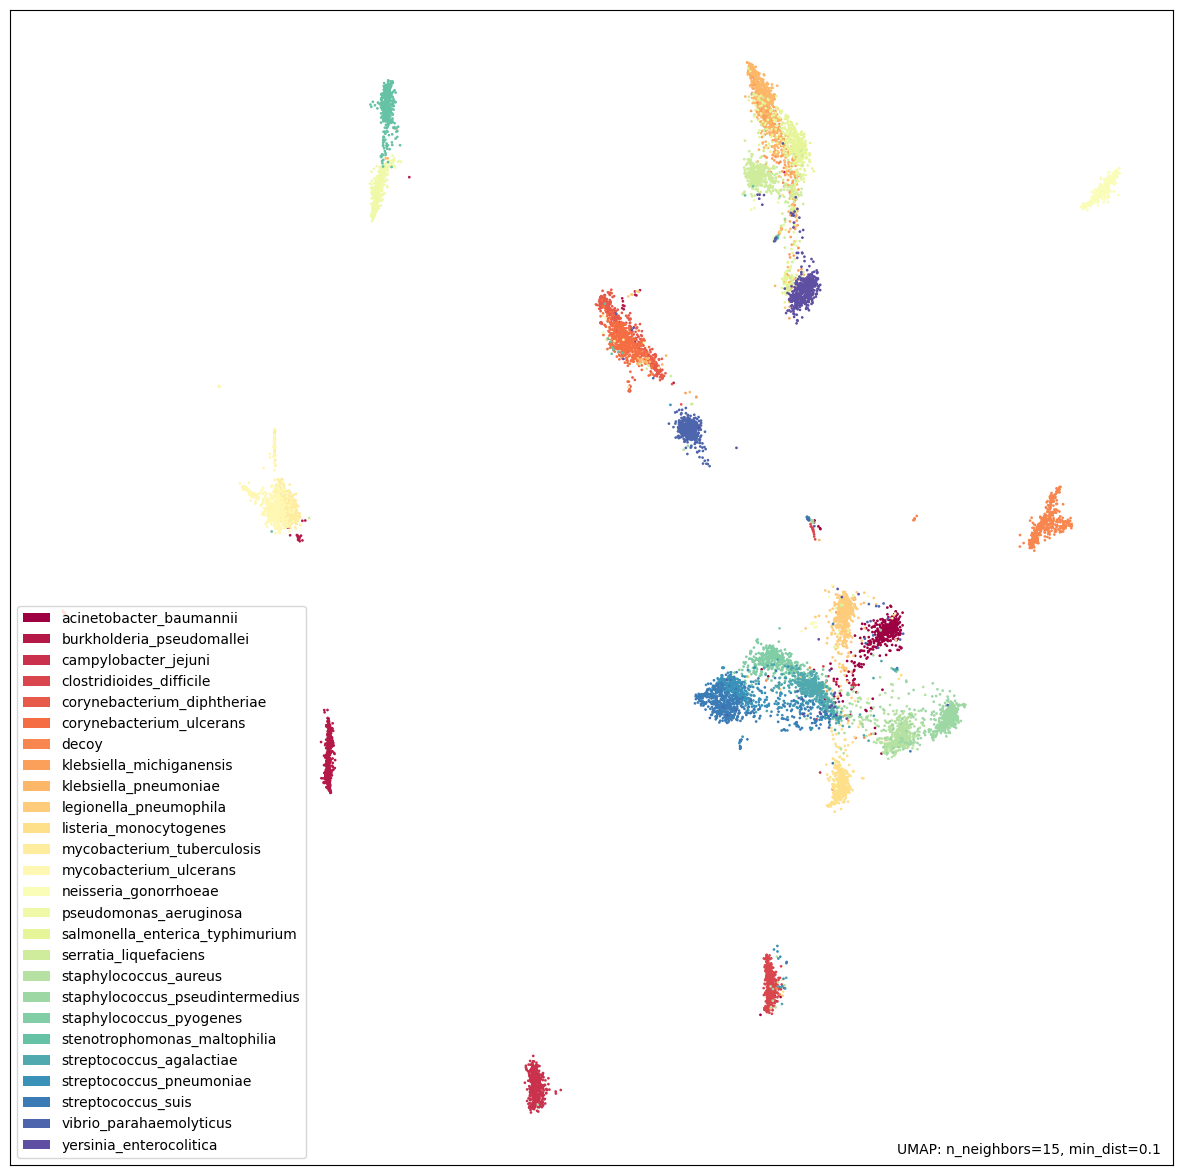

In [32]:
# the last column of our 6mer training dataset can be ignored
mapper = UMAP().fit(sampled_dataset.X[:, :-1])

labels_tc = le.inverse_transform(sampled_dataset.Y)
ax = umap.plot.points(mapper, labels=labels_tc,  width=1500, height=1500)

What interesting patterns can you notice? Some observations might be:
- Some species are pretty separated in clusters.
- Even though most species lie in separate groups, we can see some regions where points from different species are overlapping.
- There are some "lost points" for pretty much every species.

Do you think these pieces of information can help you in something? Think about it.

## Training

OK, time for training. As baseline we will choose the simplest [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) model.

You can fine-tune the logistic regression hyperparameters such as the penalty and regularization term.

```python
from sklearn.model_selection import GridSearchCV

#list of items to tune
parameters_lr = [{'penalty': ['l1','l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]

starting_time = timeit.default_timer()

regr = LogisticRegression(random_state=2023, solver='saga', n_jobs=-1, class_weight='balanced', max_iter=50, verbose=1)

grid_search_lr = GridSearchCV(estimator = regr,
                              param_grid = parameters_lr,
                              scoring = 'accuracy',
                              cv = 3,
                              n_jobs = -1)

# the last column of our 6mer training dataset can be ignored (training labels)
grid_search_lr.fit(sampled_dataset.X, sampled_dataset.Y)
best_accuracy_lr = grid_search_lr.best_score_
best_parameter_lr = grid_search_lr.best_params_

```

This might take a long time. Here, we skip this step and jump straight to training.

In [33]:
# linear classifier using scikit-learn
# Best Parameter of LR: {'C': 100, 'penalty': 'l1'}

starting_time = timeit.default_timer()

regr = LogisticRegression(C=100, penalty='l1', solver='saga', n_jobs=-1, class_weight='balanced', max_iter=500, verbose=1)
%timeit
# Train the model using the training sets
regr.fit(sampled_dataset.X, sampled_dataset.Y)
print("Time taken :", timeit.default_timer() - starting_time)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.25466873
Epoch 3, change: 0.16795731
Epoch 4, change: 0.12487443
Epoch 5, change: 0.10737931
Epoch 6, change: 0.09412063
Epoch 7, change: 0.08501854
Epoch 8, change: 0.07738841
Epoch 9, change: 0.07124992
Epoch 10, change: 0.06581432
Epoch 11, change: 0.06095470
Epoch 12, change: 0.05670308
Epoch 13, change: 0.05292854
Epoch 14, change: 0.04946849
Epoch 15, change: 0.04659808
Epoch 16, change: 0.04397807
Epoch 17, change: 0.04167227
Epoch 18, change: 0.03953671
Epoch 19, change: 0.03749164
Epoch 20, change: 0.03576042
Epoch 21, change: 0.03425859
Epoch 22, change: 0.03265324
Epoch 23, change: 0.03119795
Epoch 24, change: 0.02986192
Epoch 25, change: 0.02869974
Epoch 26, change: 0.02750283
Epoch 27, change: 0.02650732
Epoch 28, change: 0.02542344
Epoch 29, change: 0.02443062
Epoch 30, change: 0.02335459
Epoch 31, change: 0.02270343
Epoch 32, change: 0.02178278
Epoch 33, change: 0.02104477
Epoch 34, change: 0.02031742
Epoch 35, change: 0.019

KeyboardInterrupt: 

Epoch 457, change: 0.00080691
Epoch 458, change: 0.00080522
Epoch 459, change: 0.00080319
Epoch 460, change: 0.00080167
Epoch 461, change: 0.00080005
Epoch 462, change: 0.00079816
Epoch 463, change: 0.00079669
Epoch 464, change: 0.00079482
Epoch 465, change: 0.00079307
Epoch 466, change: 0.00079146
Epoch 467, change: 0.00079014
Epoch 468, change: 0.00078823
Epoch 469, change: 0.00078649
Epoch 470, change: 0.00078506
Epoch 471, change: 0.00078301
Epoch 472, change: 0.00078164
Epoch 473, change: 0.00077999
Epoch 474, change: 0.00077822
Epoch 475, change: 0.00077680
Epoch 476, change: 0.00077501
Epoch 477, change: 0.00077334
Epoch 478, change: 0.00077168
Epoch 479, change: 0.00077021
Epoch 480, change: 0.00076844
Epoch 481, change: 0.00076682
Epoch 482, change: 0.00076537
Epoch 483, change: 0.00076350
Epoch 484, change: 0.00076220
Epoch 485, change: 0.00076084
Epoch 486, change: 0.00075925
Epoch 487, change: 0.00075743
Epoch 488, change: 0.00075612
Epoch 489, change: 0.00075474
Epoch 490,

/Users/eugenegan/Documents/GitHub_repo/cs4220-pathogen-detection/new_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


We can now save our trained model for later usage. This is an example of how you can send your model to our final evaluation.

In [ ]:
from joblib import dump, load
dump(regr, 'models/baseline.joblib')

['models/baseline.joblib']

Then the model can be loaded using

```python
# load trained model
regr = load('models/baseline.joblib')
```

## Evaluation of Model

Now that you have your trained model, you can use it on each of the patient's read dataset and try to find the pathogens that appear in each patient.

Your model is evaluated based on [**Jaccard index**](https://en.wikipedia.org/wiki/Jaccard_index#Jaccard_index_in_binary_classification_confusion_matrices). For patient $i$, let $P$ be the set of pathogen species your model predicted (or $\{\text{decoy}\}$ if there is no pathogens predicted), and $T$ the set of pathogen species the patient actually have (or $\{\text{decoy}\}$ if there is no pathogens in the reads), the score for your model is

$$\text{Jaccard index}=\frac{|P\cap T|}{|P \cup T|}$$

In [34]:
def jaccard_index_per_patient(patient_id, preds):
    df_true = pd.read_csv('test_data/patient{}_labels.csv'.format(patient_id))
    tp, fp, tp_fn = 0, 0, df_true['labels'].shape[0]
    print('my predition(s) for patient {}:'.format(patient_id))
    print(preds)
    print('true pathogen')
    print(df_true['labels'].values)
    # if don't predict any pathogen, it means there is only decoy in the test dataset (your prediction)
    if len(preds) == 0:
        preds = ['decoy']
    for item in np.unique(preds):
        if item in df_true['labels'].values:
            tp += 1
        else:
            fp += 1
    #you have to predict all labels correctly, but you are penalized for any false positive
    return tp / (tp_fn + fp)

Going back to our model: since we are using logistic regression, our model will classify each read to the class that has the highest probability of having the read. If we report all the species that a read has been classified to, then we may end up with a lot of false positives (why?).

One potential way to counter this is to define a threshold. Here I used 0.95: I only report a species if I am 95% confident that one read comes from that species. Let's see how well my model will behave...

In [35]:
#prediction for all patients
threshold = 0.95

all_jaccard_index = []
for patient_id in range(10):
    print('predicting for patient {}'.format(patient_id))

    with open('test_data/patient{}_6mers.npy'.format(patient_id), 'rb') as read_file:
        df_test = np.load(read_file)

    # regr.predict relies on argmax, thus predict to every single read and you will end up with many false positives
    y_pred = regr.predict(df_test)

    # we can use regr.predict_proba to find a good threshold and predict only for case where the model is confident.
    # here I apply 0.95 as the cutoff for my predictions, let's see how well my model will behave...
    y_predprob = regr.predict_proba(df_test)

    # we get only predictions larger than the threshold and if there is more than one, we take the argmax again
    final_predictions = le.inverse_transform(
                            np.unique([np.argmax(item) for item in y_predprob if len(np.where(item >= threshold)[0]) >= 1]
                        ))

    # my pathogens dectected, decoy will be ignored
    final_predictions = [item for item in final_predictions if item !='decoy']

    ji = jaccard_index_per_patient(patient_id, final_predictions)
    print('Jaccard index: {}'.format(ji))
    all_jaccard_index.append(ji)

predicting for patient 0


AttributeError: 'LogisticRegression' object has no attribute 'coef_'

In [ ]:
print(['patient {}: {}'.format(c,item) for c, item in enumerate(all_jaccard_index)], 'avg: {}'.format(np.mean(all_jaccard_index)))

['patient 0: 1.0', 'patient 1: 0.0', 'patient 2: 0.6666666666666666', 'patient 3: 0.5', 'patient 4: 0.5', 'patient 5: 1.0', 'patient 6: 0.0', 'patient 7: 0.16666666666666666', 'patient 8: 0.5', 'patient 9: 0.3333333333333333'] avg: 0.4666666666666666


So the overall score for my model is 0.45. Not a bad start, but still much room for improvement. You don't necessarily need to work on this baseline; this was just released as an example. Have fun!!!